# WSC Project - Data Analysis & NLP

In [1]:
import os
import sys
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn
import nltk
import ast

from IPython.display import display, HTML

# Display settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print('utils.py loaded')


utils.py loaded


In [ ]:
# eda_df = pd.read_csv('data/transcripts_post_eda.csv')
# eda_df[['sample_id', 'Text', 'Label', 'EventNameCleaned']].drop_duplicates(ignore_index=True)
# print(eda_df.shape)

# folds_df = pd.read_csv('data/transcripts_train_folds.csv')
# folds_df = folds_df[['Text', 'Label', 'EventNameCleaned', 'transcript_id']]
# folds_df = folds_df.drop_duplicates(subset=['Text', 'Label', 'EventNameCleaned'])
# print(folds_df.shape)
# eda_df.merge(folds_df, on=['Text', 'Label', 'EventNameCleaned'], how='inner')[['sample_id', 'transcript_id', 'Text', 'Label', 'EventNameCleaned']].to_csv('data/ids_mapping.csv', index=False)


(1105, 9)
(1105, 4)


## Prepare Folds



In [ ]:
transcripts_df = pd.read_csv(
    'data/transcripts_tokenized.csv',
)
ACTIONS = list(set(pd.read_csv("data/actions.csv")["parameter"]))

In [3]:
WRITE = False

if WRITE:

    transcripts_folds_df = transcripts_df.reset_index(drop=True)
    transcripts_folds_df = transcripts_folds_df[['sample_id', 'Text', 'EventNameCleaned', 'tokenized_event_name', 'tokenized_text', 'actions_in_text', 'events', 'Label']]

    df = transcripts_folds_df[['sample_id','actions_in_text']].copy()

    def assign_group(g, fold):
        n = len(g)
        lab = np.empty(n, dtype=object)
        if n == 1:
            lab[0] = 'test'
        elif n == 2:
            lab[0] = 'test'
            lab[1] = 'val'
        else:
            base = np.roll(np.array(['test','val','train']), -(fold % 3))  # rotate first 3 per fold
            k = min(3, n)
            lab[:k] = base[:k]
            if n > 3:
                rng = np.random.default_rng(42 + fold)  # reproducible
                lab[3:] = rng.choice(['train','val','test'], size=n-3, p=[0.2,0.4,0.4])
        return pd.Series(lab, index=g.index)

    folds = {
        f'fold{i+1}': df.groupby('actions_in_text', group_keys=False)
                        .apply(assign_group, fold=i)
                        .reindex(df.index)
        for i in range(5)
    }

    # Create a DataFrame from the folds dictionary and merge with transcripts_folds_df
    folds_df = pd.DataFrame(folds)
    folds_df['sample_id'] = transcripts_folds_df['sample_id']
    transcripts_folds_df = transcripts_folds_df.merge(folds_df, on='sample_id', how='inner')
    transcripts_folds_df.to_csv('data/transcripts_folds.csv', index=False)
else:
    transcripts_folds_df = pd.read_csv('data/transcripts_folds.csv')

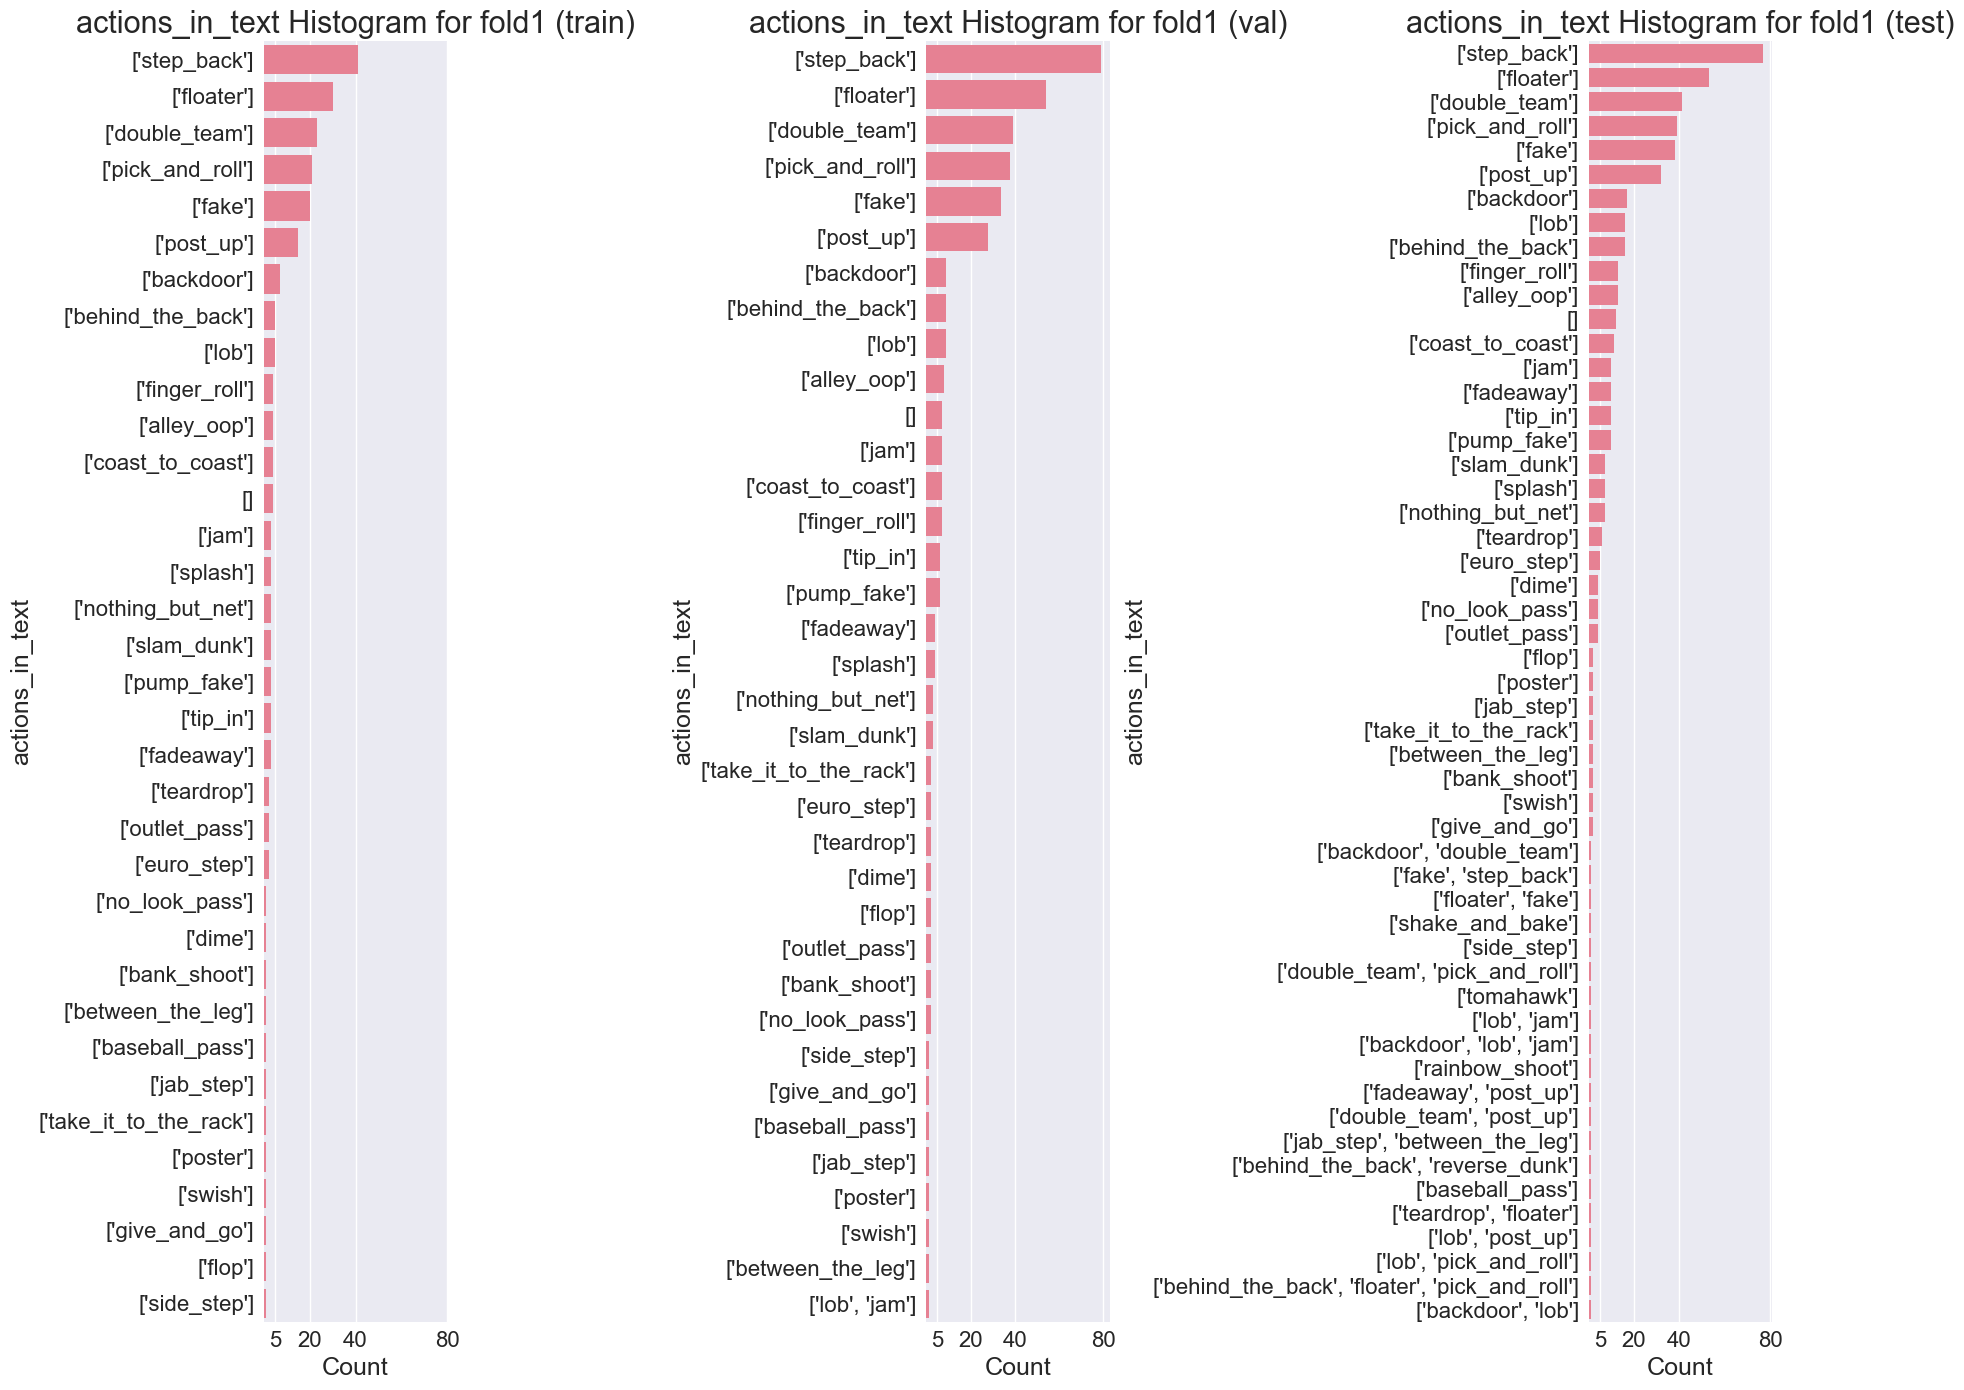

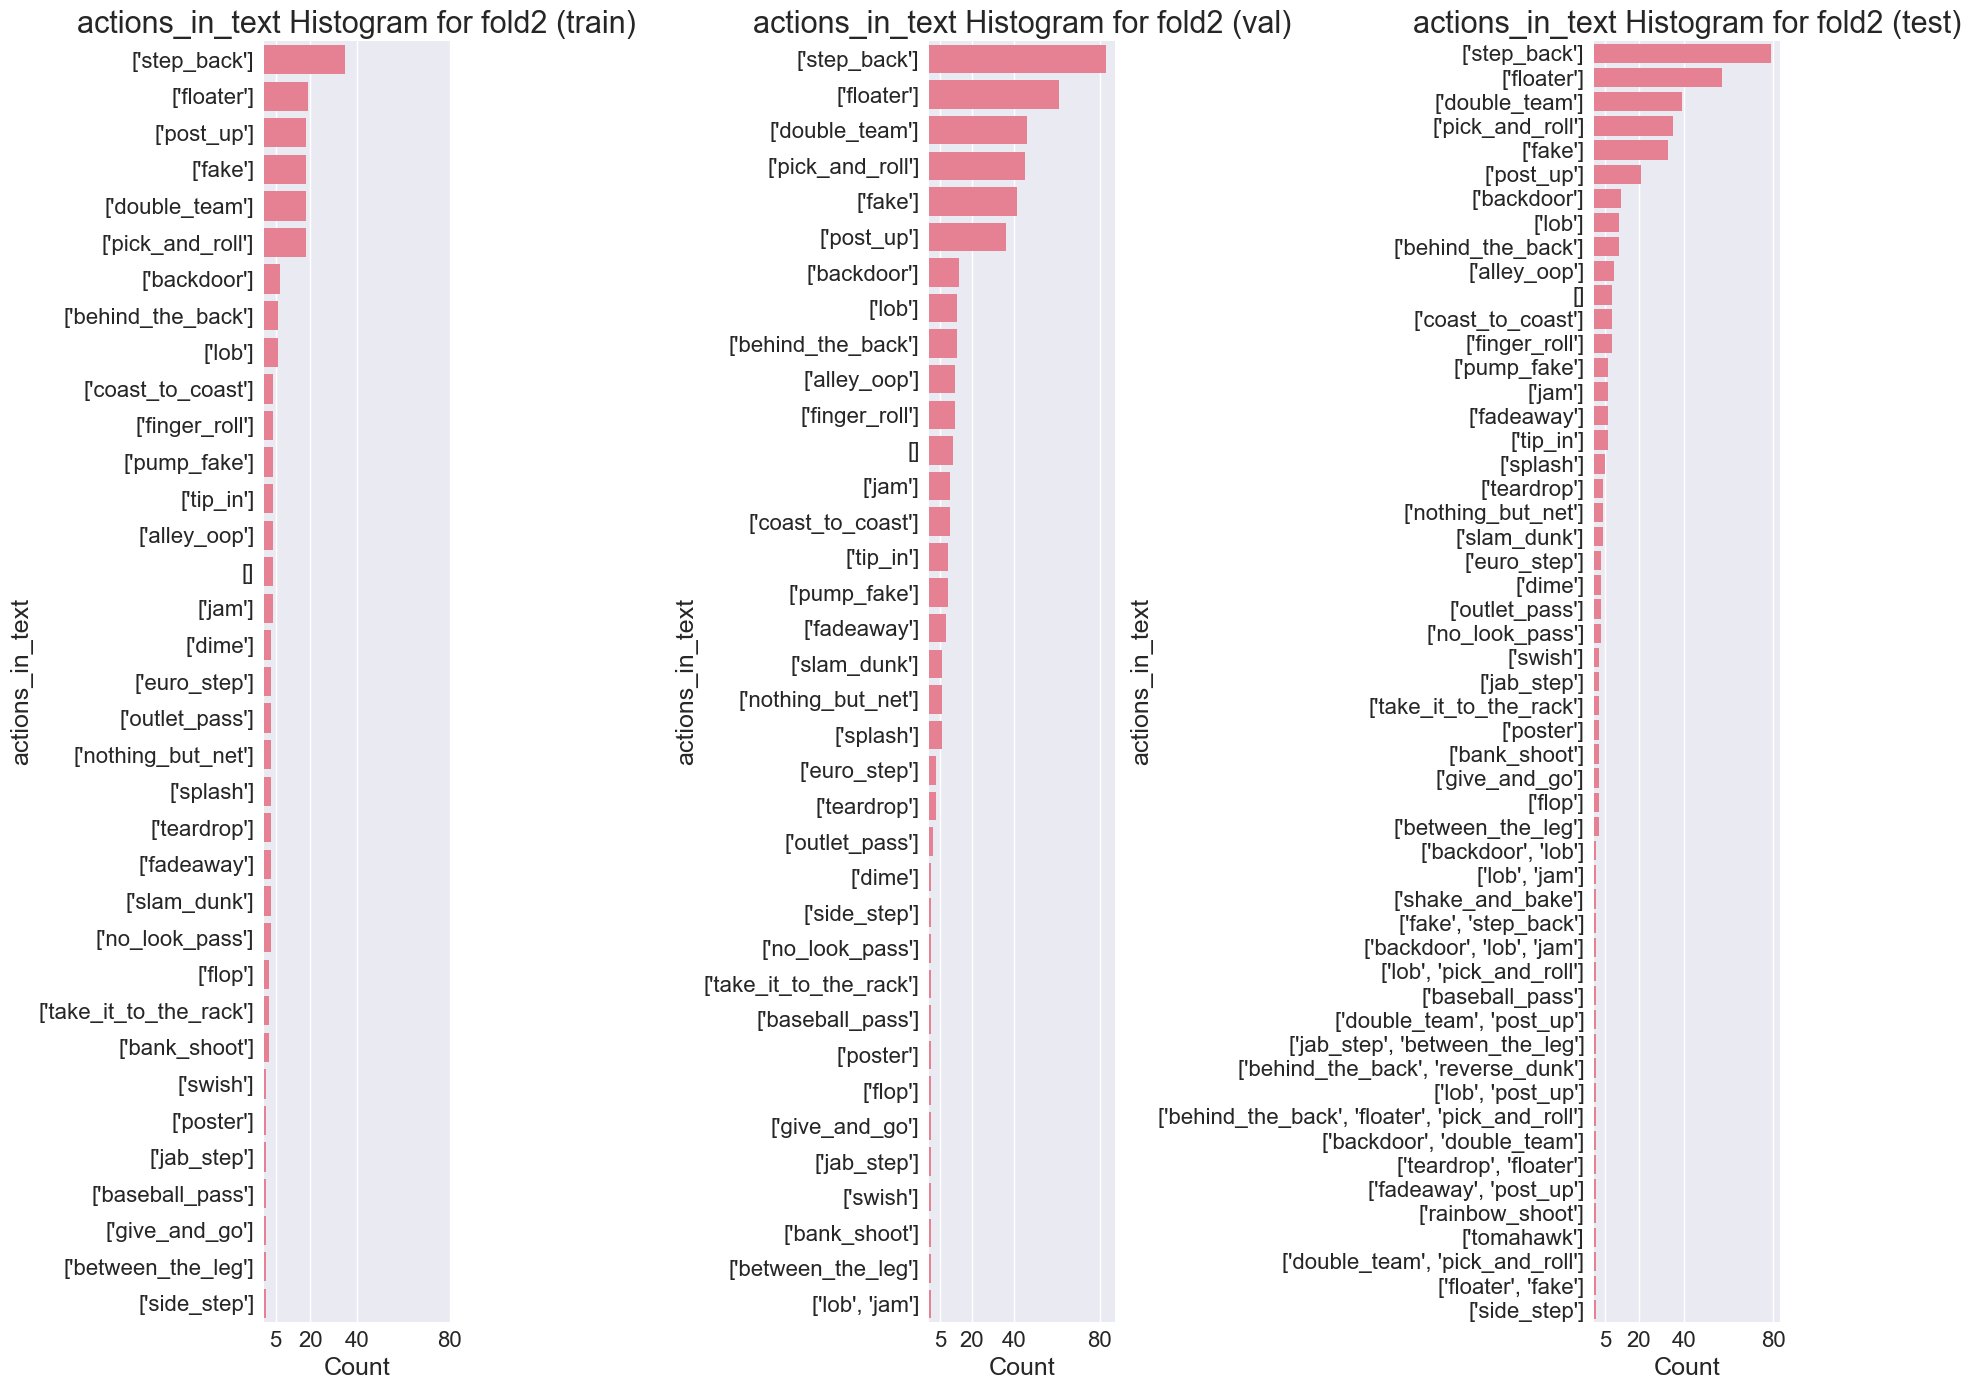

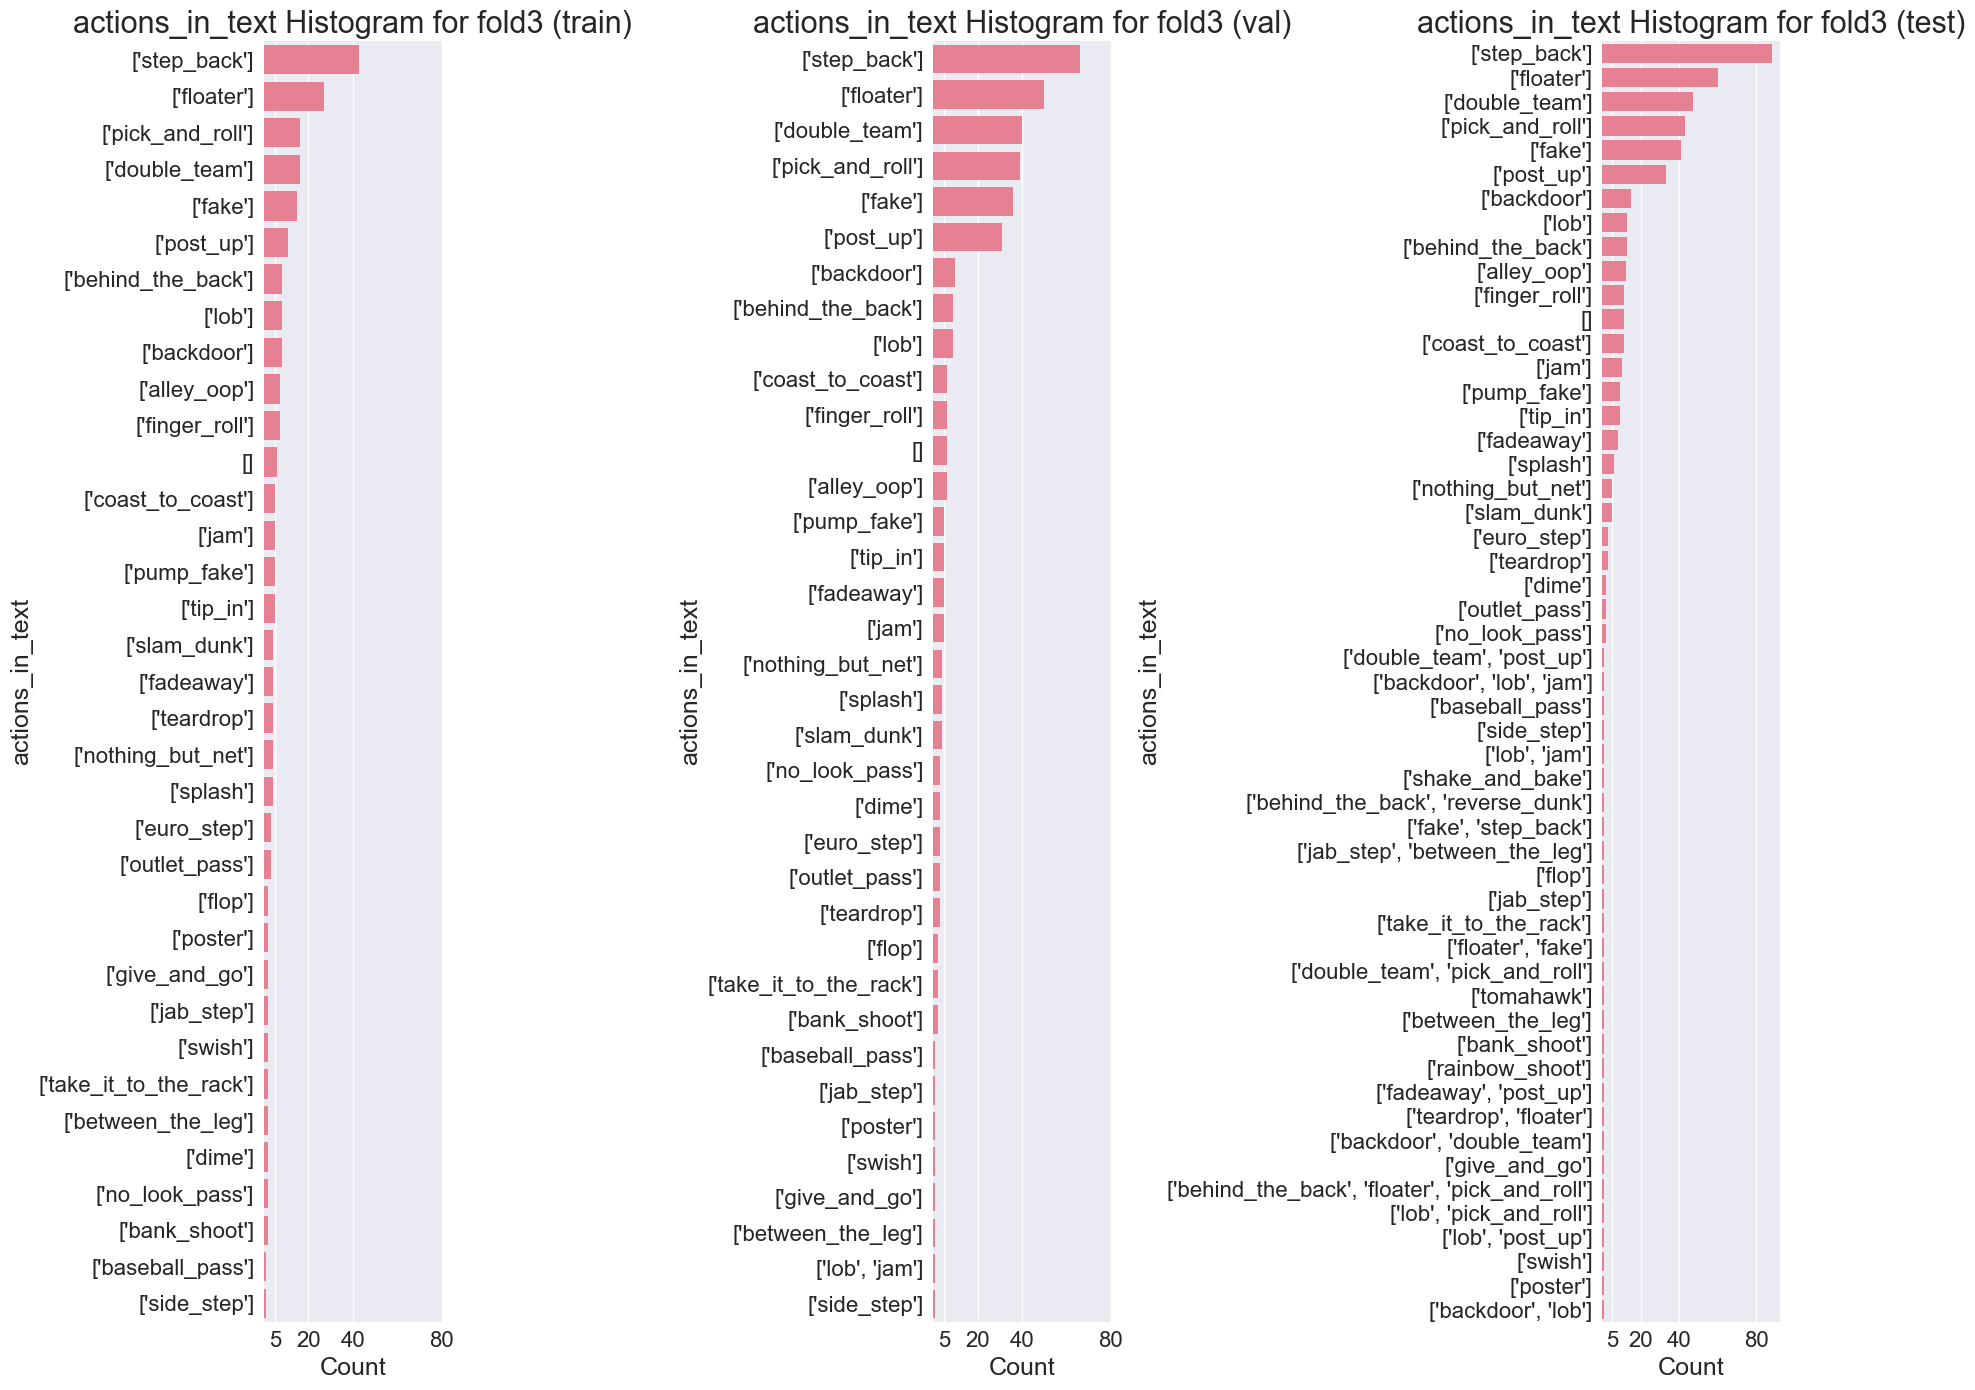

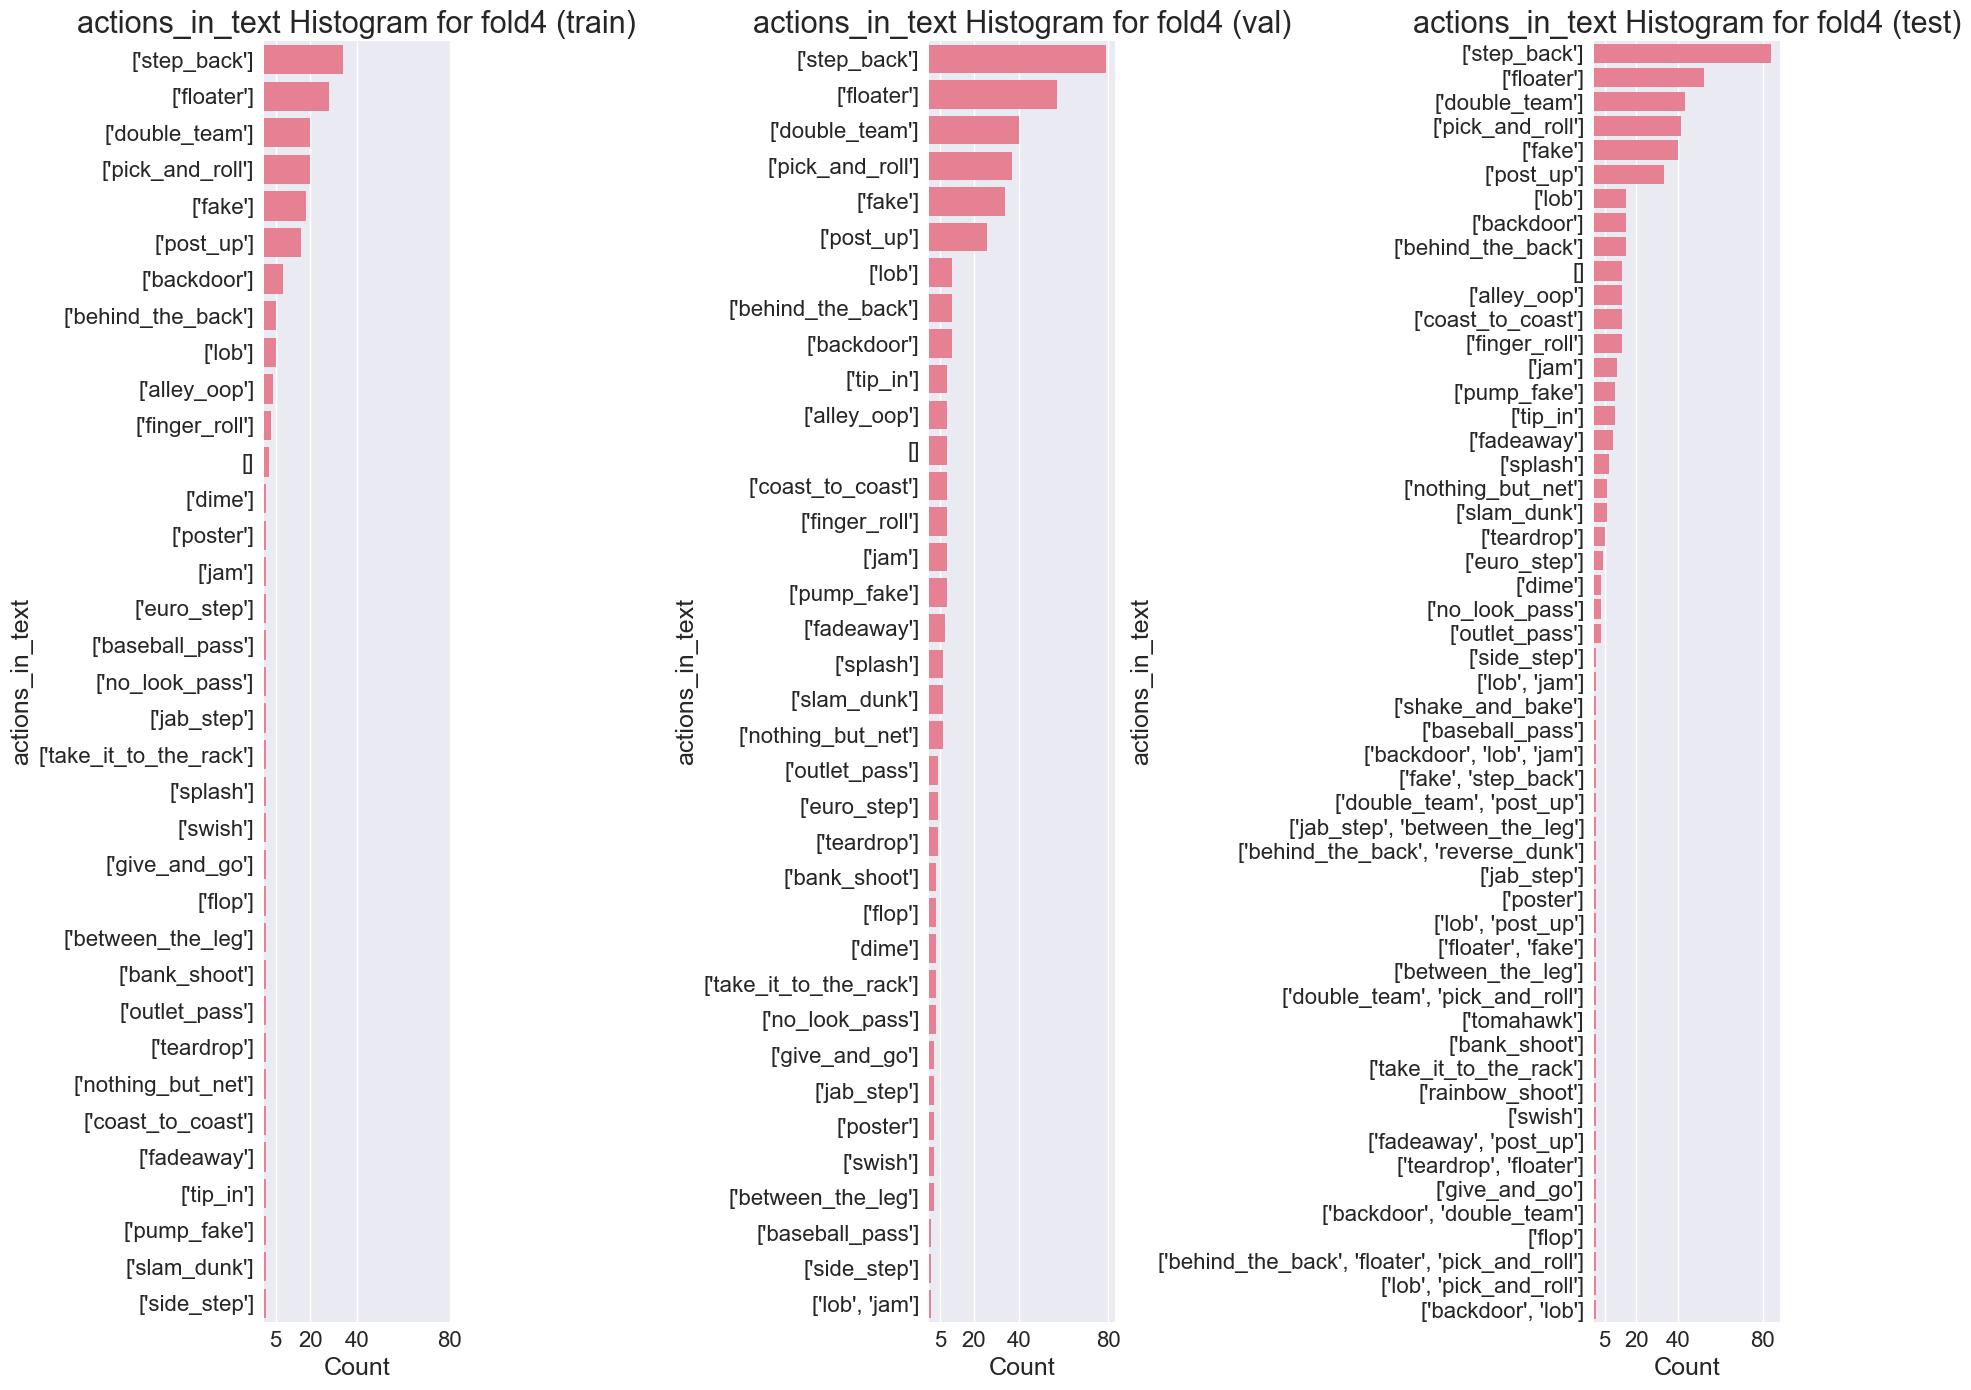

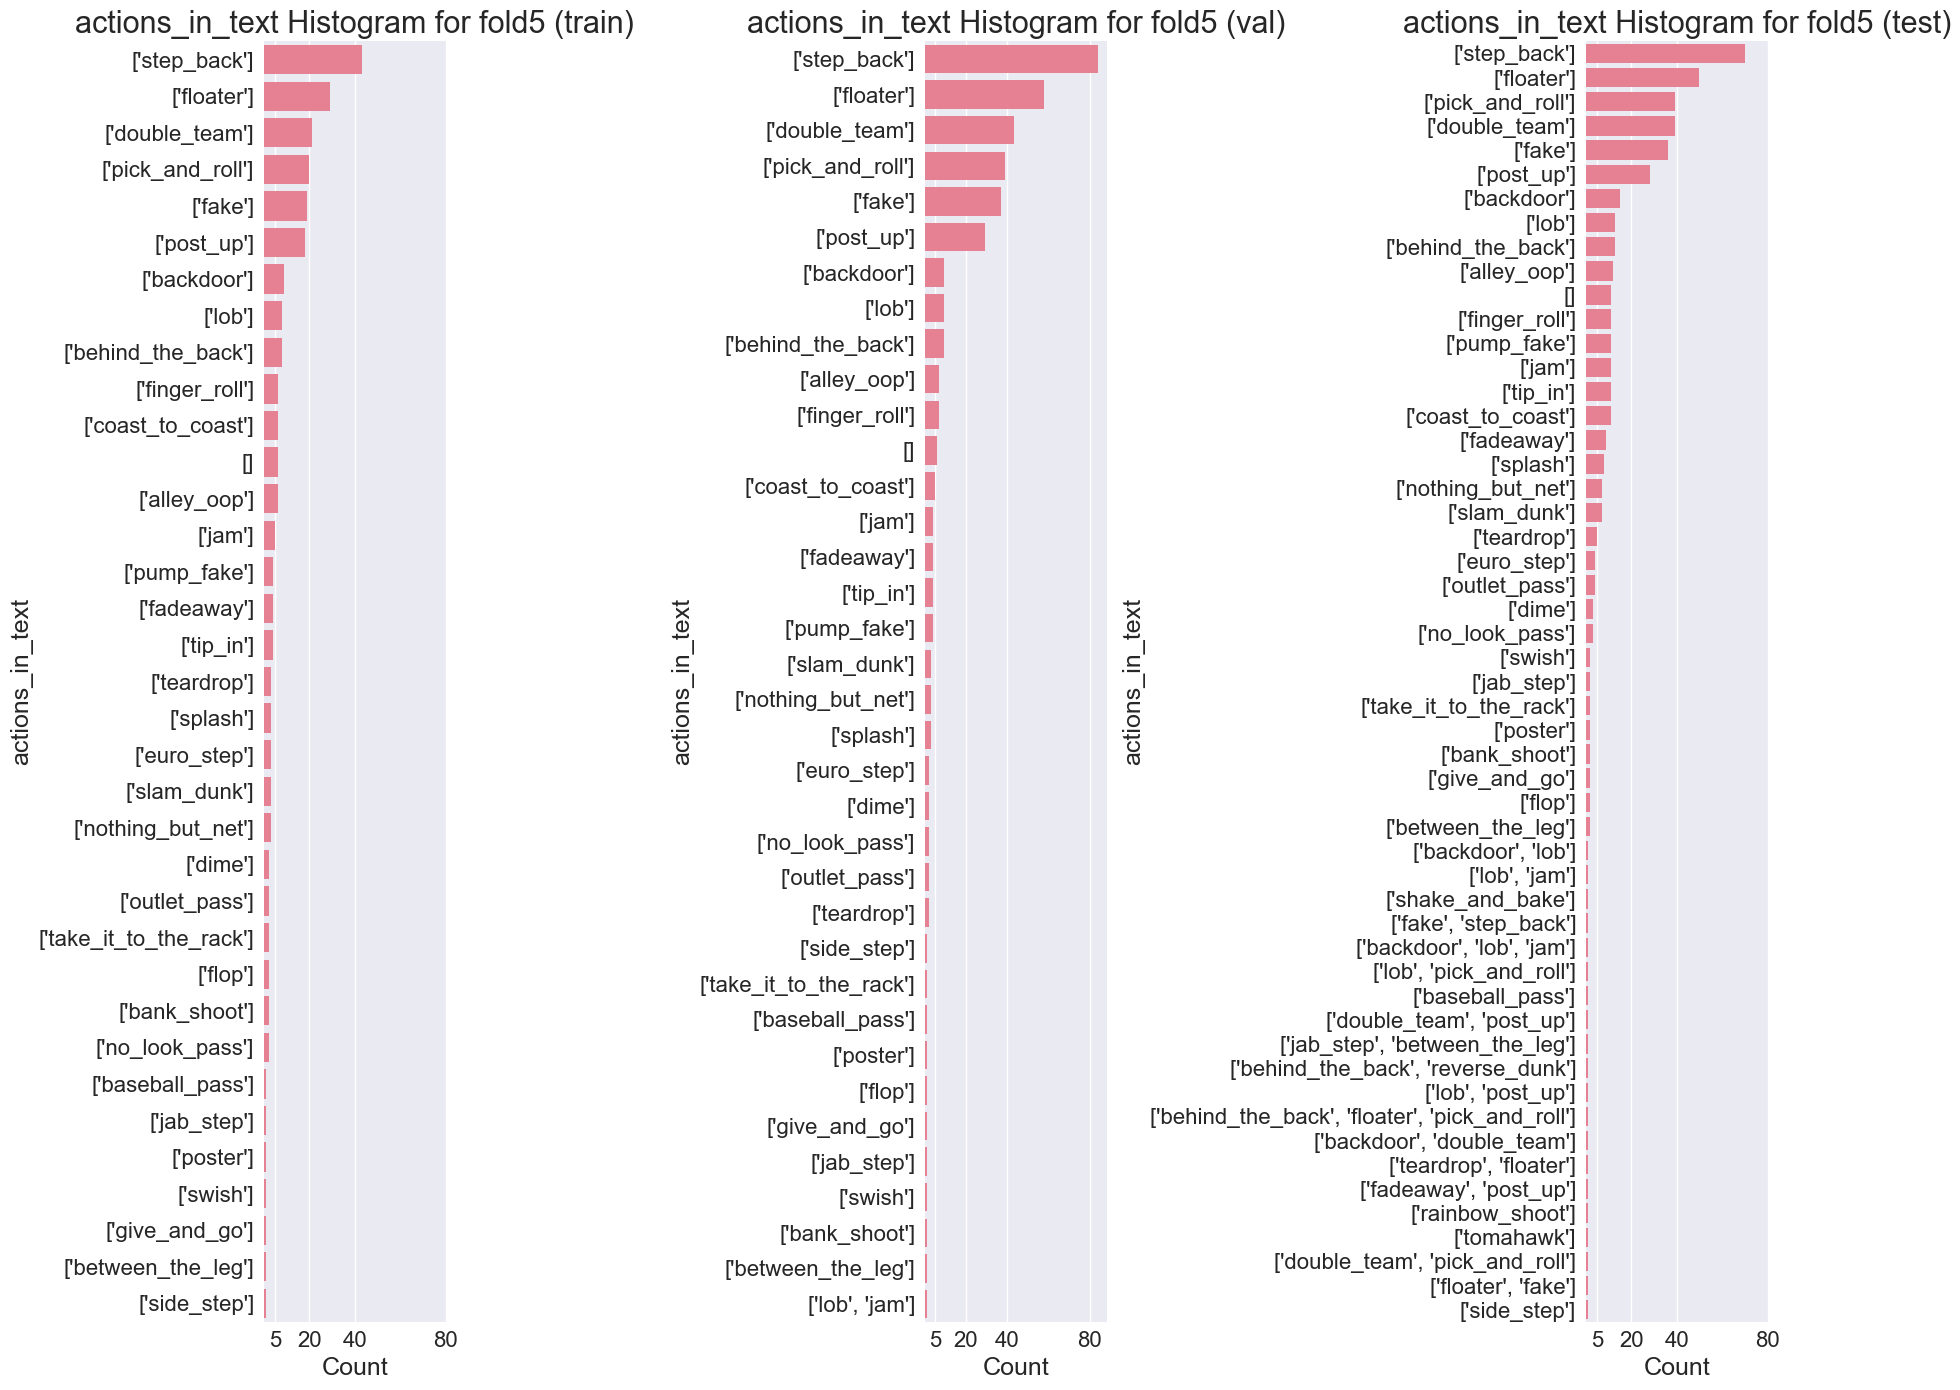

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fold_cols = [col for col in transcripts_folds_df.columns if col.startswith('fold')]
split_types = ['train', 'val', 'test']

for fold in fold_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 14))  # 1 row, 3 columns
    for i, split in enumerate(split_types):
        ax = axes[i]
        data = transcripts_folds_df[transcripts_folds_df[fold] == split]['actions_in_text']
        sns.countplot(
            y=data, 
            order=data.value_counts().index, 
            ax=ax
        )
        ax.set_title(f'actions_in_text Histogram for {fold} ({split})', fontsize=22)
        ax.set_ylabel('actions_in_text', fontsize=18)
        ax.set_xlabel('Count', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_xticks([5, 20, 40, 80])
    plt.tight_layout()
    plt.show()